# Feedback Prize - Evaluating Student Writing

The following EDA Jupyter Notebook is a combination of the work done by [Rob Mulla](https://www.kaggle.com/robikscube) ([🎓 Student Writing Competition [Twitch Stream]](https://www.kaggle.com/robikscube/student-writing-competition-twitch-stream/notebook?scriptVersionId=83303421)) and [Erik Bruin](https://www.kaggle.com/erikbruin) ([NLP on Student Writing: EDA](https://www.kaggle.com/erikbruin/nlp-on-student-writing-eda)). The code and analysis is pretty much the same, there are just some refactors and minimal additions that were made in order to combine them into a single notebook

If the notebook below was helpful in any way to you, make sure to review and upvote the original code on their Kaggle posts

In [1]:
"""
Changing working directory to repository path 
in order to make simpler references to files/folder.

Also, adding src folder in the repository to import
any code that has been moved to py files for reusability
"""

import os
REPOSITORY_PATH = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlgpu2/code/Users/santiago.a.diez/evaluating-student-writing-kaggle-challenge'
os.chdir(REPOSITORY_PATH)
import sys  
sys.path.insert(0, 'src')

In [26]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import spacy
from itertools import cycle
import seaborn as sns
from random import randint

from eswkg.config import Config

In [3]:
plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [25]:
def read_essay(essay_id):
    with open(Config.get_file_path(config_key="train_folder") + f"/{essay_id}.txt") as f:
        essay = f.read()
    return essay


def get_discourse_color_map():
    return  {
        "Lead": 1,  # 1 red
        "Position": 2,  # 2 green
        "Evidence": 3,  # 3 yellow
        "Claim": 4,  # 4 blue
        "Concluding Statement": 5,  # 5 magenta
        "Counterclaim": 6,  # 6 cyan
        "Rebuttal": 7,  # 7 white
        "None": 9,  # default
    } 


def text_to_color(essay, discourse_type, predictionstring):
    """
    Takes an entire essay, the discourse type and prediction string.
    Returns highlighted text for the prediction string
    """
    hcolor = get_discourse_color_map()[discourse_type]
    text_index = [int(c) for c in predictionstring.split()]
    text_subset = " ".join(np.array(essay.split())[text_index])

    return f"\033[4{hcolor};30m{text_subset}\033[m"


def get_discourse_prediction_strings(train, essay_id):
        discourse_prediction_strings = " ".join(train.query("id == @essay_id")["predictionstring"].values)
        return [int(c) for c in discourse_prediction_strings.split()]


def get_non_discourse_cluster(non_discourse):
    non_discourse.columns = ["predictionstring"]
    non_discourse["cluster"] = (
            non_discourse["predictionstring"].diff().fillna(1) > 1
        ).cumsum()

    return non_discourse.groupby("cluster")


def get_non_discourse_strings(non_discourse):
    non_discourse_strings = []
    for i, d in get_non_discourse_cluster(non_discourse):
        pred_string = [str(x) for x in d["predictionstring"].values]
        non_discourse_strings.append(" ".join(pred_string))
    return non_discourse_strings


def get_non_discourse_df(train, essay, essay_id):        
    non_discourse = pd.DataFrame(
        [c for c in range(len(essay.split())) if c not in get_discourse_prediction_strings(train, essay_id)]
    )

    if non_discourse.empty:
        df = pd.DataFrame(columns=train.columns)
    else:
        non_discourse_strings = get_non_discourse_strings(non_discourse)
        df = pd.DataFrame(non_discourse_strings).rename(columns={0: "predictionstring"})
        df["discourse_type"] = "None"
    
    return df


def get_colored_essay(train, essay_id):
    essay = read_essay(essay_id)
    all_text = ""
    train_subset = train.query("id == @essay_id").copy()
    df = get_non_discourse_df(train, essay, essay_id)
    train_subset = pd.concat([train_subset, df])
    train_subset["first_index"] = (
        train_subset["predictionstring"].str.split(" ").str[0].astype("int")
    )
    train_subset = train_subset.sort_values("first_index").reset_index(drop=True).copy()
    for i, d in train_subset.iterrows():
        colored_text = text_to_color(essay, d.discourse_type, d.predictionstring)
        all_text += " " + colored_text
    return all_text[1:]

In [30]:
train = pd.read_csv(Config.get_file_path(config_key="train"))
train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

sample_submission = pd.read_csv(Config.get_file_path(config_key="sample_submission"))

#The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
train_txt = glob(Config.get_file_path(config_key="train_folder") + "/*.txt") 
test_txt = glob(Config.get_file_path(config_key="test_folder") + "/*.txt")

# Introduction to the competition

Basically, we have a bunch of essays written by kids in the age range of about 12-18 years old in which we have to find word sequences that can be classified as one of 7 "discourse types". These are:

- Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- Position - an opinion or conclusion on the main question
- Claim - a claim that supports the position
- Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
- Rebuttal - a claim that refutes a counterclaim
- Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
- Concluding Statement - a concluding statement that restates the claims

Let's look at the full text of one essay first.

In [38]:
get_random_essay = True

essay_index = randint(0,len(train_txt)-1) if get_random_essay else 6316
essay_path = train_txt[essay_index]
essay_id = os.path.basename(essay_path).rsplit(".",1)[0]

print(f"- Essay index: {essay_index}")
print(f"- Essay name: {essay_id}","\n")
!cat $essay_path

- Essay index: 6316
- Essay name: 6772FAB89BC6 

Should the electoral college process be demolished? Many would say no way PROPER_NAME, but I strongly consider the electoral college process should be demolished. I believe this because I think the citizens of the U.S. should be able to vote for their favored presidential candidate directly. In reality, voters are not really voting for their presidential candidate, they are voting for a slate of voters. Below are my main reasons for why I am in favor of demolishing this electoral college

First off, let's get something straight, citizens who regularly vote in the presidential election are not really voting for their desired presidential candidate. All fifty of the U.S. states are given a certain amount of electoral votes. As the electoral college is widely regarded as a anachronism, it's not fit for the present anymore. According to the third source,

the electoral college is a non-democratic method of selecting a president that ought to

The train dataset gives us the following human annotations that are extracted from this essay.

In [39]:
train.query('id == @essay_id')

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
93803,6772FAB89BC6,1616017852273,0,87,Should the electoral college process be demoli...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12
93804,6772FAB89BC6,1616017860206,87,162,but I strongly consider the electoral college ...,Position,Position 1,13 14 15 16 17 18 19 20 21 22 23
93805,6772FAB89BC6,1616076818912,163,291,I believe this because I think the citizens of...,Claim,Claim 1,24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3...
93806,6772FAB89BC6,1616076828432,305,406,voters are not really voting for their preside...,Claim,Claim 2,48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 6...
93807,6772FAB89BC6,1616017899398,494,655,"First off, let's get something straight, citiz...",Claim,Claim 3,81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 9...
93808,6772FAB89BC6,1616017928583,656,1046,All fifty of the U.S. states are given a certa...,Evidence,Evidence 1,104 105 106 107 108 109 110 111 112 113 114 11...
93809,6772FAB89BC6,1616076929340,1047,1220,There are five reasons why the electoral colle...,Counterclaim,Counterclaim 1,170 171 172 173 174 175 176 177 178 179 180 18...
93810,6772FAB89BC6,1616076939880,1221,1341,these are the reasons ehy the electoral colleg...,Evidence,Evidence 2,195 196 197 198 199 200 201 202 203 204 205 20...
93811,6772FAB89BC6,1616017964249,1342,1460,"In continuation, people who vote should be abl...",Claim,Claim 4,216 217 218 219 220 221 222 223 224 225 226 22...
93812,6772FAB89BC6,1616017980676,1461,1916,That basically means whoever's name was checke...,Evidence,Evidence 3,237 238 239 240 241 242 243 244 245 246 247 24...


Kaggle provides the following field descriptions:

- id - ID code for essay response
- discourse_id - ID code for discourse element
- discourse_start - character position where discourse element begins in the essay response
- discourse_end - character position where discourse element ends in the essay response
- discourse_text - text of discourse element
- discourse_type - classification of discourse element
- discourse_type_num - enumerated class label of discourse element
- predictionstring - the word indices of the training sample, as required for predictions

The Ground Truth here is a combination of the discourse type and the prediction string. The predictionstring corresponds to the index of the words in the essay and the predicted discourse type for this sequence of words should be correct. There can be partial matches, if the correct discourse type is predicted but on a longer or shorter sequence of words than specified in the Ground Truth.

Not necessarily all text of an essay is part of a discourse. In some cases, a title is present which is not part of any discourse.

# discourse_type

Is there a correlation between the length of a discourse and the class (discourse_type)? Yes, there is. Evidence is the longest discount type on average. When looking at the frequencies of occurence, we see that Counterclaim and Rebuttal are relatively rare

In [40]:
train.query('id == @essay_id')["discourse_type"].value_counts()

Claim                   4
Evidence                3
Lead                    1
Position                1
Counterclaim            1
Concluding Statement    1
Name: discourse_type, dtype: int64

In [41]:
all_text = get_colored_essay(train, essay_id)
print(all_text)

Should the electoral college process be demolished? Many would say no way PROPER_NAME, but I strongly consider the electoral college process should be demolished. I believe this because I think the citizens of the U.S. should be able to vote for their favored presidential candidate directly. In reality, voters are not really voting for their presidential candidate, they are voting for a slate of voters. Below are my main reasons for why I am in favor of demolishing this electoral college First off, let's get something straight, citizens who regularly vote in the presidential election are not really voting for their desired presidential candidate. All fifty of the U.S. states are given a certain amount of electoral votes. As the electoral college is widely regarded as a anachronism, it's not fit for the present anymore. According to the third source, the electoral college is a non-democratic method of selecting a president that ought to be overruled by declaing that the candidate who re

## What Type of Annotations are Most Common
- Are there trends to when and where annotations appear in the text?
- What type of annotations are important?

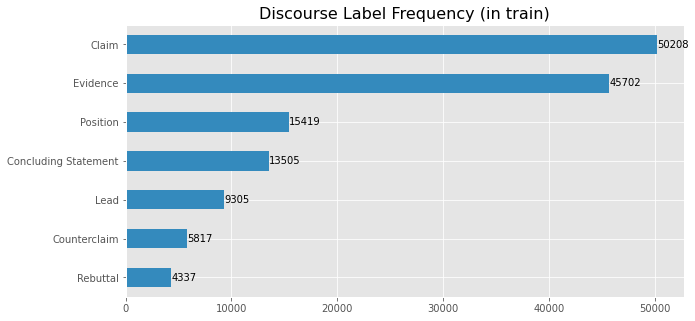

In [43]:
def plot_discourse_label_frequency(train):
    ax = (
        train["discourse_type"]
        .value_counts(ascending=True)
        .plot(kind="barh", figsize=(10, 5), color=color_pal[1])
    )
    ax.set_title("Discourse Label Frequency (in train)", fontsize=16)
    ax.bar_label(ax.containers[0], label_type="edge")
    plt.show()

plot_discourse_label_frequency(train)

Some things to note about this next plot.
- The lead tends to start at the beginning of the document. Evidence ranges in the area it appears commonly in the document.

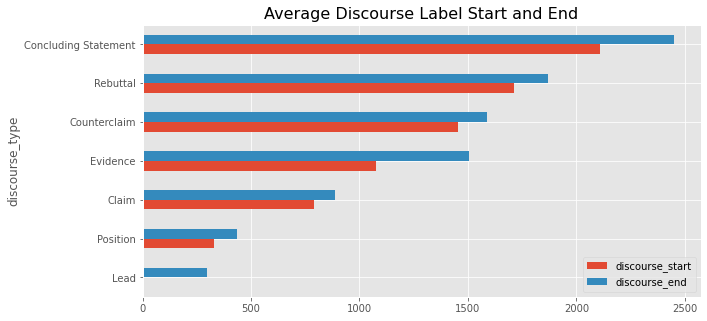

In [44]:
def plot_discourse_label_intervals(train):
    ax = (
        train.groupby("discourse_type")[["discourse_start", "discourse_end"]]
        .mean()
        .sort_values("discourse_start")
        .plot(
            kind="barh",
            figsize=(10, 5),
        )
    )
    ax.set_title("Average Discourse Label Start and End", fontsize=16)
    plt.show()

plot_discourse_label_intervals(train)

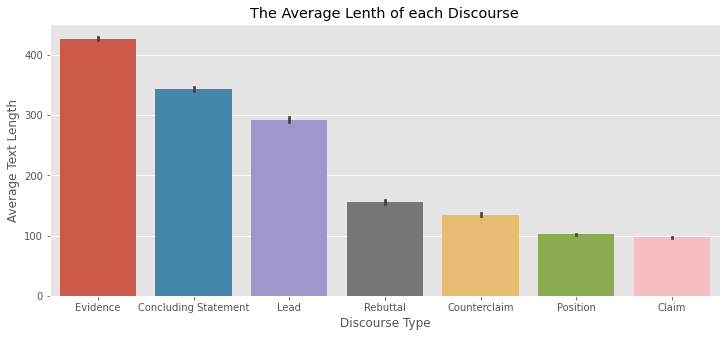

In [46]:
def plot_discourse_label_length(train):
    # The length of each label
    train["discourse_len"] = (train["discourse_end"] - train["discourse_start"]).astype(
        "int"
    )
    plot_order  = train.groupby('discourse_type')['discourse_len'].mean().sort_values(ascending=False).index.values

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(x="discourse_type", y="discourse_len", data=train, order=plot_order)
    ax.set_title("The Average Lenth of each Discourse")
    ax.set_xlabel("Discourse Type")
    ax.set_ylabel("Average Text Length")
    plt.show()

plot_discourse_label_length(train)

Discourse type num:
- Almost 15% contain no Concluding Statement
- 40% don't have a Lead 
- Majority of essays have:
    - 1 Position
    - 1 Concluding Statement
    - up to 3 Evidences and Claims
    - 1 Lead

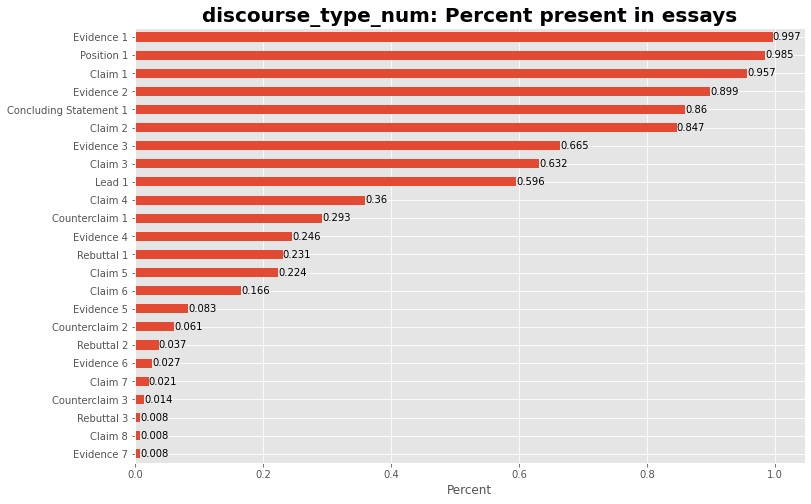

In [51]:
def plot_discourse_type_num_frequency(train, threshold=0.03):
    av_per_essay = train['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
    av_per_essay['perc'] = round((av_per_essay['count'] / train.id.nunique()),3)
    av_per_essay = av_per_essay.set_index('discourse_type_num')
    
    fig = plt.figure(figsize=(12,8))
    ax = av_per_essay.query('perc > @threshold')['perc'].plot(kind="barh")
    ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
    ax.bar_label(ax.containers[0], label_type="edge")
    ax.set_xlabel("Percent")
    ax.set_ylabel("")
    plt.show()

plot_discourse_type_num_frequency(train, threshold=0.005)

However, I am also interested in the relative positions of discourse types with the essays. Therefore, I am adding this number in the loop below. I think the main takeaway is that the Lead (if it's there!) is almost always the first discourse in an essay.

**More on this in the next version.**

In [56]:
train['discourse_nr'] = 1
counter = 1

for i in range(1, len(train)):
    if train.loc[i, 'id'] == train.loc[i-1, 'id']:
        counter += 1
    else:
        counter = 1
    train.loc[i, 'discourse_nr'] = counter
        
av_position = train.groupby('discourse_type')['discourse_nr'].mean().sort_values()
av_position

discourse_type
Lead                    1.004514
Position                2.201116
Claim                   5.163480
Evidence                6.627478
Counterclaim            7.304968
Rebuttal                8.684344
Concluding Statement    9.644650
Name: discourse_nr, dtype: float64

# discourse_text and predictionstring
Below is a check to validate if the discourse_text and the predictionstring always have the same number of words (as they should).

In [57]:
#add columns
train["discourse_len"] = train["discourse_text"].apply(lambda x: len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x: len(x.split()))

cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
0,1622627660524,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,1622627653021,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,1622627671020,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,1622627696365,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,1622627759780,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


There are 468 discourses where this goes wrong (by one word)

In [44]:
print(f"- The total number of discourses is {len(train)}")

discourse_len_not_equal_to_pred_len = train.query('discourse_len != pred_len')
print(f"- The total number of discourses where discourse lenght does not equal prediction string length is {len(discourse_len_not_equal_to_pred_len)}")
discourse_len_not_equal_to_pred_len[cols_to_display]

- The total number of discourses is 144293
- The total number of discourses where discourse lenght does not equal prediction string length is 468


,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
107,1622473475289,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,1622564912260,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8
1525,1622992466917,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,1622992280991,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,1622992426147,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...
142607,1617826841342,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,1617887956153,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,1617652582742,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,1618286838241,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


Let's check the first one.

In [57]:
discourse_id_sample = discourse_len_not_equal_to_pred_len.iloc[0]["discourse_id"]
train_sample = train.query('discourse_id == @discourse_id_sample') 

In [58]:
print(train_sample['discourse_text'].values[0])
print(train_sample['discourse_text'].values[0].split())
print(len(train_sample['discourse_text'].values[0].split()))

if we would just make stricker laws for phone an driving the people would stop because of the consequences.      
['if', 'we', 'would', 'just', 'make', 'stricker', 'laws', 'for', 'phone', 'an', 'driving', 'the', 'people', 'would', 'stop', 'because', 'of', 'the', 'consequences.']
19


In [59]:
print(train_sample['predictionstring'].values[0])
print(train_sample['predictionstring'].values[0].split())
print(len(train_sample['predictionstring'].values[0].split()))

303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
['303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320']
18


The length of 19 words seems correct and the length of the predictionstring also really seems to be 18. Something to keep in mind.

# Investigation the gaps between Annotations (text not used as discourse_text)

Just taking the last discourse_end in train is not entirely correct as a last piece of text may not have been used as a discourse.

In [59]:
len_dict = {}
word_dict = {}
for t in train_txt:
    with open(t, "r") as txt_file:
        myid = t.split("/")[-1].replace(".txt", "")
        data = txt_file.read()
        mylen = len(data.strip())
        myword = len(data.split())
        len_dict[myid] = mylen
        word_dict[myid] = myword
train["essay_len"] = train["id"].map(len_dict)
train["essay_words"] = train["id"].map(word_dict)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
train.groupby("id").first().plot(
    x="essay_len", y="essay_words", kind="scatter", color=color_pal[3], ax=ax
)
ax.set_title("Word vs Character Length per Essay", fontsize=16)
plt.show()

When comparing the discourse_end of the last discourse in each essay, we see that the discourse_end is sometimes larger than the essay_len. This cannot be right, but I will assume that those are last pieces of text in the essay indeed.

In [ ]:
#initialize column
train['gap_length'] = np.nan

#set the first one
train.loc[0, 'gap_length'] = 7 #discourse start - 1 (previous end is always -1)

#loop over rest
for i in tqdm(range(1, len(train))):
    #gap if difference is not 1 within an essay
    if ((train.loc[i, "id"] == train.loc[i-1, "id"])\
        and (train.loc[i, "discourse_start"] - train.loc[i-1, "discourse_end"] > 1)):
        train.loc[i, 'gap_length'] = train.loc[i, "discourse_start"] - train.loc[i-1, "discourse_end"] - 2
        #minus 2 as the previous end is always -1 and the previous start always +1
    #gap if the first discourse of an new essay does not start at 0
    elif ((train.loc[i, "id"] != train.loc[i-1, "id"])\
        and (train.loc[i, "discourse_start"] != 0)):
        train.loc[i, 'gap_length'] = train.loc[i, "discourse_start"] -1


 #is there any text after the last discourse of an essay?
last_ones = train.drop_duplicates(subset="id", keep='last')
last_ones['gap_end_length'] = np.where((last_ones.discourse_end < last_ones.essay_len),\
                                       (last_ones.essay_len - last_ones.discourse_end),\
                                       np.nan)

cols_to_merge = ['id', 'discourse_id', 'gap_end_length']
train = train.merge(last_ones[cols_to_merge], on = ["id", "discourse_id"], how = "left")

  0%|          | 0/144292 [00:00<?, ?it/s]

In [ ]:
#display an example
cols_to_display = ['id', 'discourse_start', 'discourse_end', 'discourse_type', 'essay_len', 'gap_length', 'gap_end_length']
train[cols_to_display].query('id == "AFEC37C2D43F"')

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
144270,AFEC37C2D43F,0,317,Lead,3140,NaN,NaN
144271,AFEC37C2D43F,318,515,Position,3140,NaN,NaN
144272,AFEC37C2D43F,684,692,Claim,3140,167.0,NaN
144273,AFEC37C2D43F,693,710,Claim,3140,NaN,NaN
144274,AFEC37C2D43F,714,724,Claim,3140,2.0,NaN
144275,AFEC37C2D43F,725,1360,Evidence,3140,NaN,NaN
144276,AFEC37C2D43F,1361,1471,Claim,3140,NaN,NaN
144277,AFEC37C2D43F,1472,1881,Evidence,3140,NaN,NaN
144278,AFEC37C2D43F,1882,2019,Claim,3140,NaN,NaN
144279,AFEC37C2D43F,2029,2123,Claim,3140,8.0,NaN


In [ ]:
#how many pieces of text are not used as discourses?
print(f"Besides the {len(train)} discourse texts, there are {len(train.query('gap_length.notna()', engine='python'))+ len(train.query('gap_end_length.notna()', engine='python'))} pieces of text not classified.")

Besides the 144293 discourse texts, there are 32162 pieces of text not classified.


Although the gaps in the example above are small, we do have huge gaps in a number of essays.

In [ ]:
train.sort_values(by = "gap_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
12921,7330313ED3F0,3377,3846,Concluding Statement,3829,2245.0,NaN
20537,7DF12B42AB72,3596,4231,Rebuttal,6012,2232.0,NaN
11685,4DF55925F544,2845,3013,Evidence,3846,2137.0,NaN
88336,43CBE96B374E,3115,3371,Concluding Statement,3689,1726.0,318.0
103994,134A4DA02013,2049,2176,Claim,3301,1680.0,NaN


In [ ]:
train.sort_values(by = "gap_end_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
28134,C278EDC82048,524,667,Evidence,8015,NaN,7348.0
8567,129497C3E0FC,386,443,Position,3616,103.0,3173.0
1204,F92664C55FBB,541,628,Evidence,3767,NaN,3139.0
91438,F5EE08CB44B9,124,353,Claim,3022,NaN,2669.0
6110,8E3B8CFD4256,1111,1295,Claim,3821,NaN,2526.0


Below, you can see a histogram of the length of all gaps with the outliers taken out (all gaps longer than 300 characters).

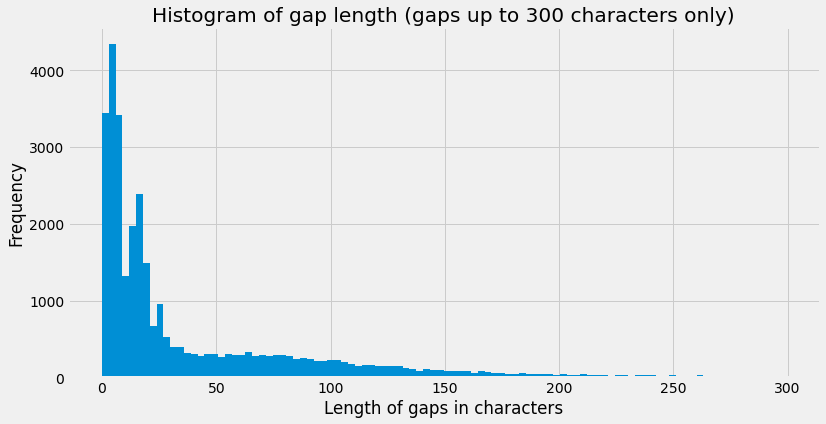

In [ ]:
all_gaps = (train.gap_length[~train.gap_length.isna()]).append((train.gap_end_length[~train.gap_end_length.isna()]), ignore_index= True)
#filter outliers
all_gaps = all_gaps[all_gaps<300]
fig = plt.figure(figsize=(12,6))
all_gaps.plot.hist(bins=100)
plt.title("Histogram of gap length (gaps up to 300 characters only)")
plt.xticks(rotation=0)
plt.xlabel("Length of gaps in characters")
plt.show()

# Most used words per Discourse Type
Now, I want to find out which words are used the most for each discourse_type (stopwords excluded). I have also taken out some extra words that were all over the place in the figures for each discourse_type. I am not sure how useful this is. A first thing that I notice is that "however," is used a lot in Rebuttal.

In [23]:
train['discourse_text'] = train['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put series of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train['discourse_type'].unique():
    df = train.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True) #to series
    counts_dict[dt] = df1


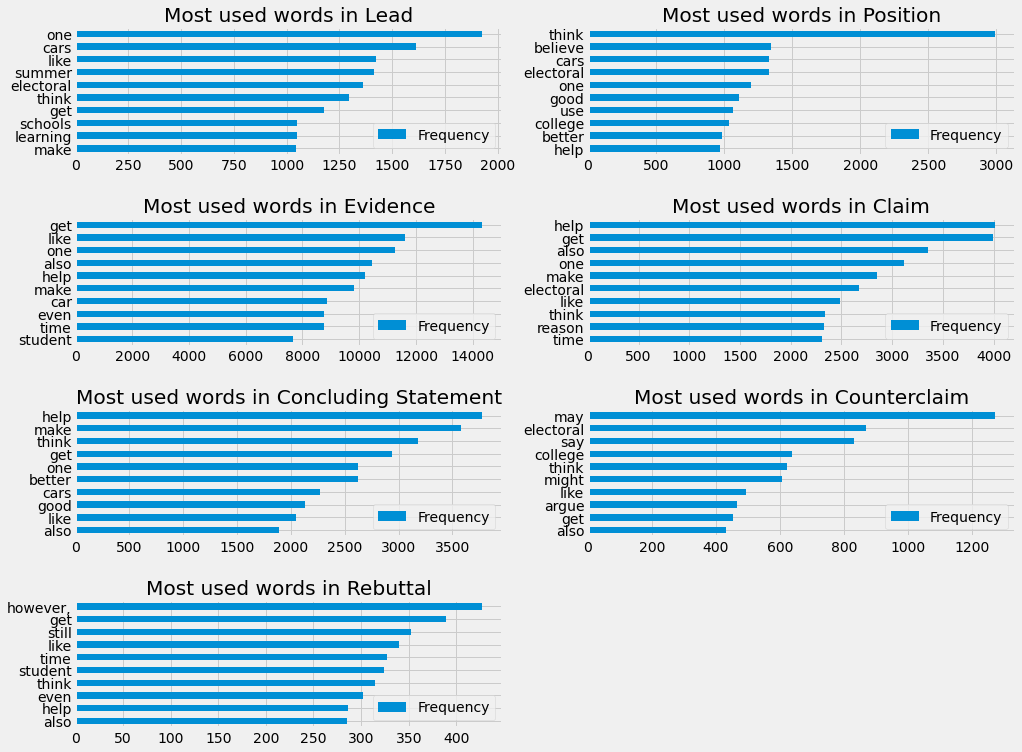

In [24]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")